In [3]:
import praw
import numpy as np
import pandas as pd

from textblob import TextBlob

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

from collections import defaultdict
import operator
from fuzzywuzzy import fuzz

# Import raw data

In [4]:
df = pd.read_csv('data.csv')
df['first_op_comment'] = df['first_op_comment'].fillna(value='')
df.dropna(subset=['post_title'],inplace=True)

# Import PI processes

In [3]:
processes = pd.read_csv('processes.csv')
scripts = pd.read_csv('scripts.csv')
processes['type'] = pd.Series(dtype=str)
processes['type'].fillna(value='Process',inplace=True)
scripts['type'] = pd.Series(dtype=str)
objs = pd.concat([processes,scripts])
objs['type'].fillna(value='Script',inplace=True)
objs['name_lower'] = objs['Name'].map(lambda x: x.lower())
abbrevs = defaultdict(lambda :np.nan,{
    'DynamicBackgroundExtraction' : 'dbe',
    'LocalHistogramEqualization' : 'lhe',
    'MultiscaleLinearTransform' : 'mlt',
    'MultiscaleMedianTransform' : 'mmt',
    'PhotometricColorCalibration' : 'pcc',
    'ScreenTransferFunction' : 'stf',
    'BatchPreprocessing' : 'bpp',
    
})
objs['abbrev'] = objs['Name'].map(lambda x: abbrevs[x])
commonNames = ['Crop','Divide','Invert','NewImage','Preferences',
               'Resample','Rescale','Rotation','Script','Statistics']
objs.drop(objs[objs['Name'].map(lambda x: x in commonNames)].index,inplace=True)


In [4]:
objs.head()

,Name,type,name_lower,abbrev
0,ACDNR,Process,acdnr,NaN
1,ATrousWaveletTransform,Process,atrouswavelettransform,NaN
2,ATrousWaveletTransform2,Process,atrouswavelettransform2,NaN
3,AdaptiveStretch,Process,adaptivestretch,NaN
4,Annotation,Process,annotation,NaN


# Extract process lists from comments

In [5]:
def getProcessList(s):
    position = dict()
    lower = s.lower()
    for _,row in objs.iterrows():
        nameRE = '\s' + ('\s*'.join(row['name_lower']))
        nameMatch = re.search(nameRE,lower)
        nameLoc = -1
        abbrevLoc = -1
        if nameMatch:
            # Found full name
            nameLoc = nameMatch.start()
        if not row.isnull()['abbrev']:
            # An abbreviation exists
            abbrevRE = '\s' + row['abbrev'] + '\s'
            abbrevMatch = re.search(abbrevRE,lower)
            if abbrevMatch:
                abbrevLoc = abbrevMatch.start()

        if min(nameLoc,abbrevLoc)>0:
            # Both positive
            position[row['Name']] = min(nameLoc,abbrevLoc)
        elif max(nameLoc,abbrevLoc)>0:
            # one positive
            position[row['Name']] = max(nameLoc,abbrevLoc)
    return sorted(position.keys(),key=position.__getitem__)

In [65]:
def getProcessList(s):
    positions = dict()
    lower = s.lower()
    for _,row in objs.iterrows():
        nameRE = '\s' + ('\s*'.join(row['name_lower']))
        abbrevRE = ''
        if not row.isnull()['abbrev']:
            # An abbreviation exists
            abbrevRE = '|\s' + row['abbrev'] + '\s'
        regex = '(?:' + nameRE + abbrevRE + ')'
        
        reIterator = re.finditer(regex,lower)
        locations = [m.start() for m in reIterator]
        for l in locations:
            positions[l] = row['Name']
        
    return [positions[k] for k in sorted(positions.keys())]

In [67]:
getProcessList(df.loc[28,'first_op_comment'])

['SubframeSelector',
 'StarAlignment',
 'ImageIntegration',
 'LinearFit',
 'SubframeSelector',
 'DynamicBackgroundExtraction',
 'Deconvolution',
 'DynamicPSF',
 'MultiscaleMedianTransform',
 'HistogramTransformation',
 'ScreenTransferFunction',
 'CurvesTransformation']

In [68]:
df['processes_used'] = df['first_op_comment'].map(getProcessList)

# Import object names and catalog numbers

In [51]:
messier = re.compile('M\s*(\d{1,3})')
ngc = re.compile('NGC\s*(\d{1,4})')
df['messier_list'] = df['post_title'].map(lambda x: [int(num) for num in messier.findall(x)])
df['ngc_list'] = df['post_title'].map(lambda x: [int(num) for num in ngc.findall(x)])

In [52]:
messierList = pd.read_excel('MessierObjects.xls',header=2)
messierList.head()

,ObjectNum,Name,Type,Constellation,RAHour,RAMinute,DecSign,DecDeg,DecMinute,Magnitude,Info,Distance (ly)
0,1,NGC 1952 Crab Nebula,Supernova Remnant,Taurus,5,34.5,+,22,1.0,8.4,Size: 6.0x4.0,6300
1,2,NGC 7089,Globular Cluster,Aquarius,21,33.5,-,0,49.0,6.5,Size: 12.9,37500
2,3,NGC 5272,Globular Cluster,Canes Venatici,13,42.2,+,28,23.0,6.2,Size: 16.2,33900
3,4,NGC 6121,Globular Cluster,Scorpius,16,23.6,-,26,32.0,5.6,Size: 26.3,7200
4,5,NGC 5904,Globular Cluster,Serpens Caput,15,18.6,+,2,5.0,5.6,Size: 17.4,24500


In [53]:
nameSplitter = re.compile('(?:NGC *(\d{1,4}))? *(.*)')

def safeInt(x):
    if x == '':
        return np.nan
    else:
        return int(x)
    
def processOtherNames(s):
    s = s.replace('¹',"'")
    splitString = re.split('[,/]',s)
    words = s.split(' ')
    if words[-1] in ['Galaxy','Nebula'] and len(splitString) > 1:
        splitString = [name.strip() + ' ' + words[-1] for name in splitString[:-1]] + [splitString[-1]]
    out = [name.strip() for name in splitString]
    if out == ['']:
        out = np.nan
    return out
    
messierList['NGC'] = messierList['Name'].map(lambda x: safeInt(nameSplitter.findall(x)[0][0]))
messierList['other_names'] = messierList['Name'].map(lambda x: processOtherNames(nameSplitter.findall(x)[0][1]))

ngcList = pd.read_excel('NGCObjects.xls',header=2)
mergedDSOs = pd.merge(ngcList,messierList,how='left',left_on='ObjectNum',right_on='NGC')
objectList = mergedDSOs[['ObjectNum_x','ObjectNum_y','other_names','Type_x']]
objectList.columns = ['NGC','Messier','other_names','Type']
objectList.head()

,NGC,Messier,other_names,Type
0,1,NaN,NaN,Galaxy
1,2,NaN,NaN,Galaxy
2,3,NaN,NaN,Galaxy
3,4,NaN,NaN,Galaxy
4,5,NaN,NaN,Galaxy


## Manually adjust a few names

In [54]:
objectList.at[1975,'other_names'] = ['Orion Nebula',"Orion's Nebula"]
objectList.at[204,'other_names'] = np.nan
objectList.at[220,'other_names'] = np.nan
objectList.at[6602,'other_names'] = np.nan
objectList.at[6993,'other_names'] = np.nan
objectList.at[2631,'other_names'] = ['Beehive Cluster']
objectList.at[2023,'other_names'] = ['Flame Nebula']
objectList.at[6542,'other_names'] = ["Cat's Eye Nebula"]
objectList.at[2391,'other_names'] = ['Eskimo Nebula']
objectList.at[7661,'other_names'] = ['Blue Snowball']
objectList.at[2263,'other_names'] = ['Cone Nebula']
objectList.at[597,'other_names'] = ['Triangulum Galaxy']
objectList.at[6204,'other_names'] = ['Hercules Cluster']
objectList[~(objectList['other_names'].isnull())]

,NGC,Messier,other_names,Type
223,224,31.0,[Andromeda Galaxy],Galaxy
597,598,33.0,[Triangulum Galaxy],Galaxy
649,650,76.0,"[Little Dumbell Nebula, Cork Nebula, Butterfly...",Planetary Nebula
1067,1068,77.0,[Cetus A],Galaxy
1951,1952,1.0,[Crab Nebula],Nebula
1975,1976,42.0,"[Orion Nebula, Orion's Nebula]",Nebula
1981,1982,43.0,[de Mairan's Nebula],Nebula
2023,2024,NaN,[Flame Nebula],Nebula
2263,2264,NaN,[Cone Nebula],Cluster Nebulosity
2391,2392,NaN,[Eskimo Nebula],Planetary Nebula


In [107]:
objectList['Type'] = objectList['Type'].fillna(value='?')

/opt/conda/envs/capstone/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [ ]:
simpleType = {'Galaxy': 'Galaxy',
 'Open Cluster': 'Cluster',
 'Globular Cluster': 'Cluster',
 'Cluster Nebulosity': 'Nebula',
 'Nebula': 'Nebula',
 'Planetary Nebula': 'Nebula',
 'Star': 'Stars',
 'Double Star': 'Stars',
 'Triple Star': 'Stars',
 'Asterism': 'Stars',
 'Nebulosity in External Galaxy': 'Galaxy',
 '?': '?'}

In [109]:
objectList['simpleType'] = objectList['Type'].map(lambda x: simpleType[x])

/opt/conda/envs/capstone/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [111]:
objectList['simpleType'].value_counts()

Galaxy     6046
Cluster     681
?           630
Nebula      326
Stars       157
Name: simpleType, dtype: int64

In [114]:
objectList.set_index('NGC',inplace=True)

In [155]:
objectList.to_pickle('ngcDatabase.pkl')

In [55]:
def maxSimilarity(name,title):
    nameWords = name.split()
    titleWords = title.split()
    maxSim = 0
    for i in range(len(titleWords)-len(nameWords)+1):
        maxSim = max(maxSim,fuzz.ratio(name,' '.join(titleWords[i:i+len(nameWords)])))
    return maxSim

def getOtherNamesNGC(title,sens=85):
    out = []
    for namedObject in objectList[~(objectList['other_names'].isnull())].iterrows():
        for name in namedObject[1]['other_names']:
            sim = maxSimilarity(name,title)
            if sim>sens:
                out.append(int(namedObject[1]['NGC']))
                break
    return out

df['other_names_NGC'] = df['post_title'].map(getOtherNamesNGC)

In [56]:
def messierToNGC(n):
    if(n in objectList['Messier'].values):
        return int(objectList[objectList['Messier'] == n]['NGC'])
    
def combineObjects(row):
    messierObjects = []
    for m in row['messier_list']:
        ngc = messierToNGC(m)
        if ngc:
            messierObjects.append(ngc)

    return list(set(row['ngc_list'] + messierObjects + row['other_names_NGC']))

df['dso_list'] = df.apply(combineObjects,axis=1)

In [140]:
def isType(ngcObjs,objType):
    return any(objectList.loc[ngcObjs]['simpleType'] == objType)

In [150]:
for t in objectList['simpleType'].unique():
    df['has_' + t] = df['dso_list'].map(lambda x: isType(x,t))

In [ ]:
df.to_pickle('processedData.pkl')

In [152]:
dfUse = df[df['dso_list'].map(lambda x: len(x)>0) & df['processes_used'].map(lambda x: len(x) > 1)]

In [153]:
dfUse.head()

,submission_id,post_title,link_flair,created_utc,author,url,first_op_comment,score,processes_used,messier_list,ngc_list,other_names_NGC,dso_list,has_Galaxy,has_?,has_Stars,has_Nebula,has_Cluster
28,8f3jqj,I discovered a new low-surface-brightness gala...,DSOs,1.524757e+09,mrstaypuft,https://i.imgur.com/Ceg3sc1.jpg,Hey APers - I am really excited that I can fin...,16.0,"[SubframeSelector, StarAlignment, ImageIntegra...",[],[2655],[],[2655],True,False,False,False,False
35,8ezrax,"NGC 1579, The Northern Trifid",DSOs,1.524714e+09,themongoose85,http://sirius-astrophotography.com:8000/NGC-15...,I gathered the data for this image between Jan...,4.0,"[BatchPreprocessing, LinearFit, DynamicBackgro...",[],[1579],[],[1579],False,False,False,True,False
63,8ep3s2,Finally happy with my star colors - NGC5367,DSOs,1.524613e+09,furgle,https://i.redd.it/1n6k84kl0yt01.png,NGC5367 is a reflection nebula 2000 light year...,8.0,"[LinearFit, Deconvolution, BackgroundNeutraliz...",[],[5367],[],[5367],False,False,False,True,False
79,8eixzh,M51 - Whirlpool galaxy widefield with close up...,DSOs,1.524559e+09,darkarchon11,https://i.imgur.com/IqUVEce.jpg,Shot with Atik 383L+ and D5100 on two scopes s...,13.0,"[ImageCalibration, Debayer, Blink, SubframeSel...",[51],[],[5194],[5194],True,False,False,False,False
88,8efqxb,M51 - Whirlpool Galaxy,DSOs,1.524524e+09,TROPiCALRUBi,https://imgur.com/a/rm82QR7,**Equipment**\r\n***\r\nSkywatcher EQ6 Pro\r\n...,4.0,"[DynamicCrop, HistogramTransformation, Unsharp...",[51],[],[5194],[5194],True,False,False,False,False


In [70]:
d = defaultdict(int)
for row in dfUse['dso_list']:
    for item in row:
        d[item] += 1
        
mostPhotos = sorted(list(d.items()),key = lambda x: (-x[1],x[0]))
objects = [item[0] for item in mostPhotos]
count = [item[1] for item in mostPhotos]
print(objects[:10])
print(count[:10])

[1976, 224, 3031, 5194, 3034, 598, 6618, 2024, 6853, 5457]
[102, 75, 47, 36, 32, 30, 30, 24, 24, 23]


In [71]:
objectNames = ['Orion Nebula', 'Andromeda Galaxy', "Bode's Galaxy",
               'Whirlpool Galaxy', 'Cigar Galaxy', 'Omega Nebula',
               'Triangulum Galaxy', 'Dumbbell Nebula',  'Flame Nebula',
               'Pinwheel Galaxy']

In [158]:
import matplotlib
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 220

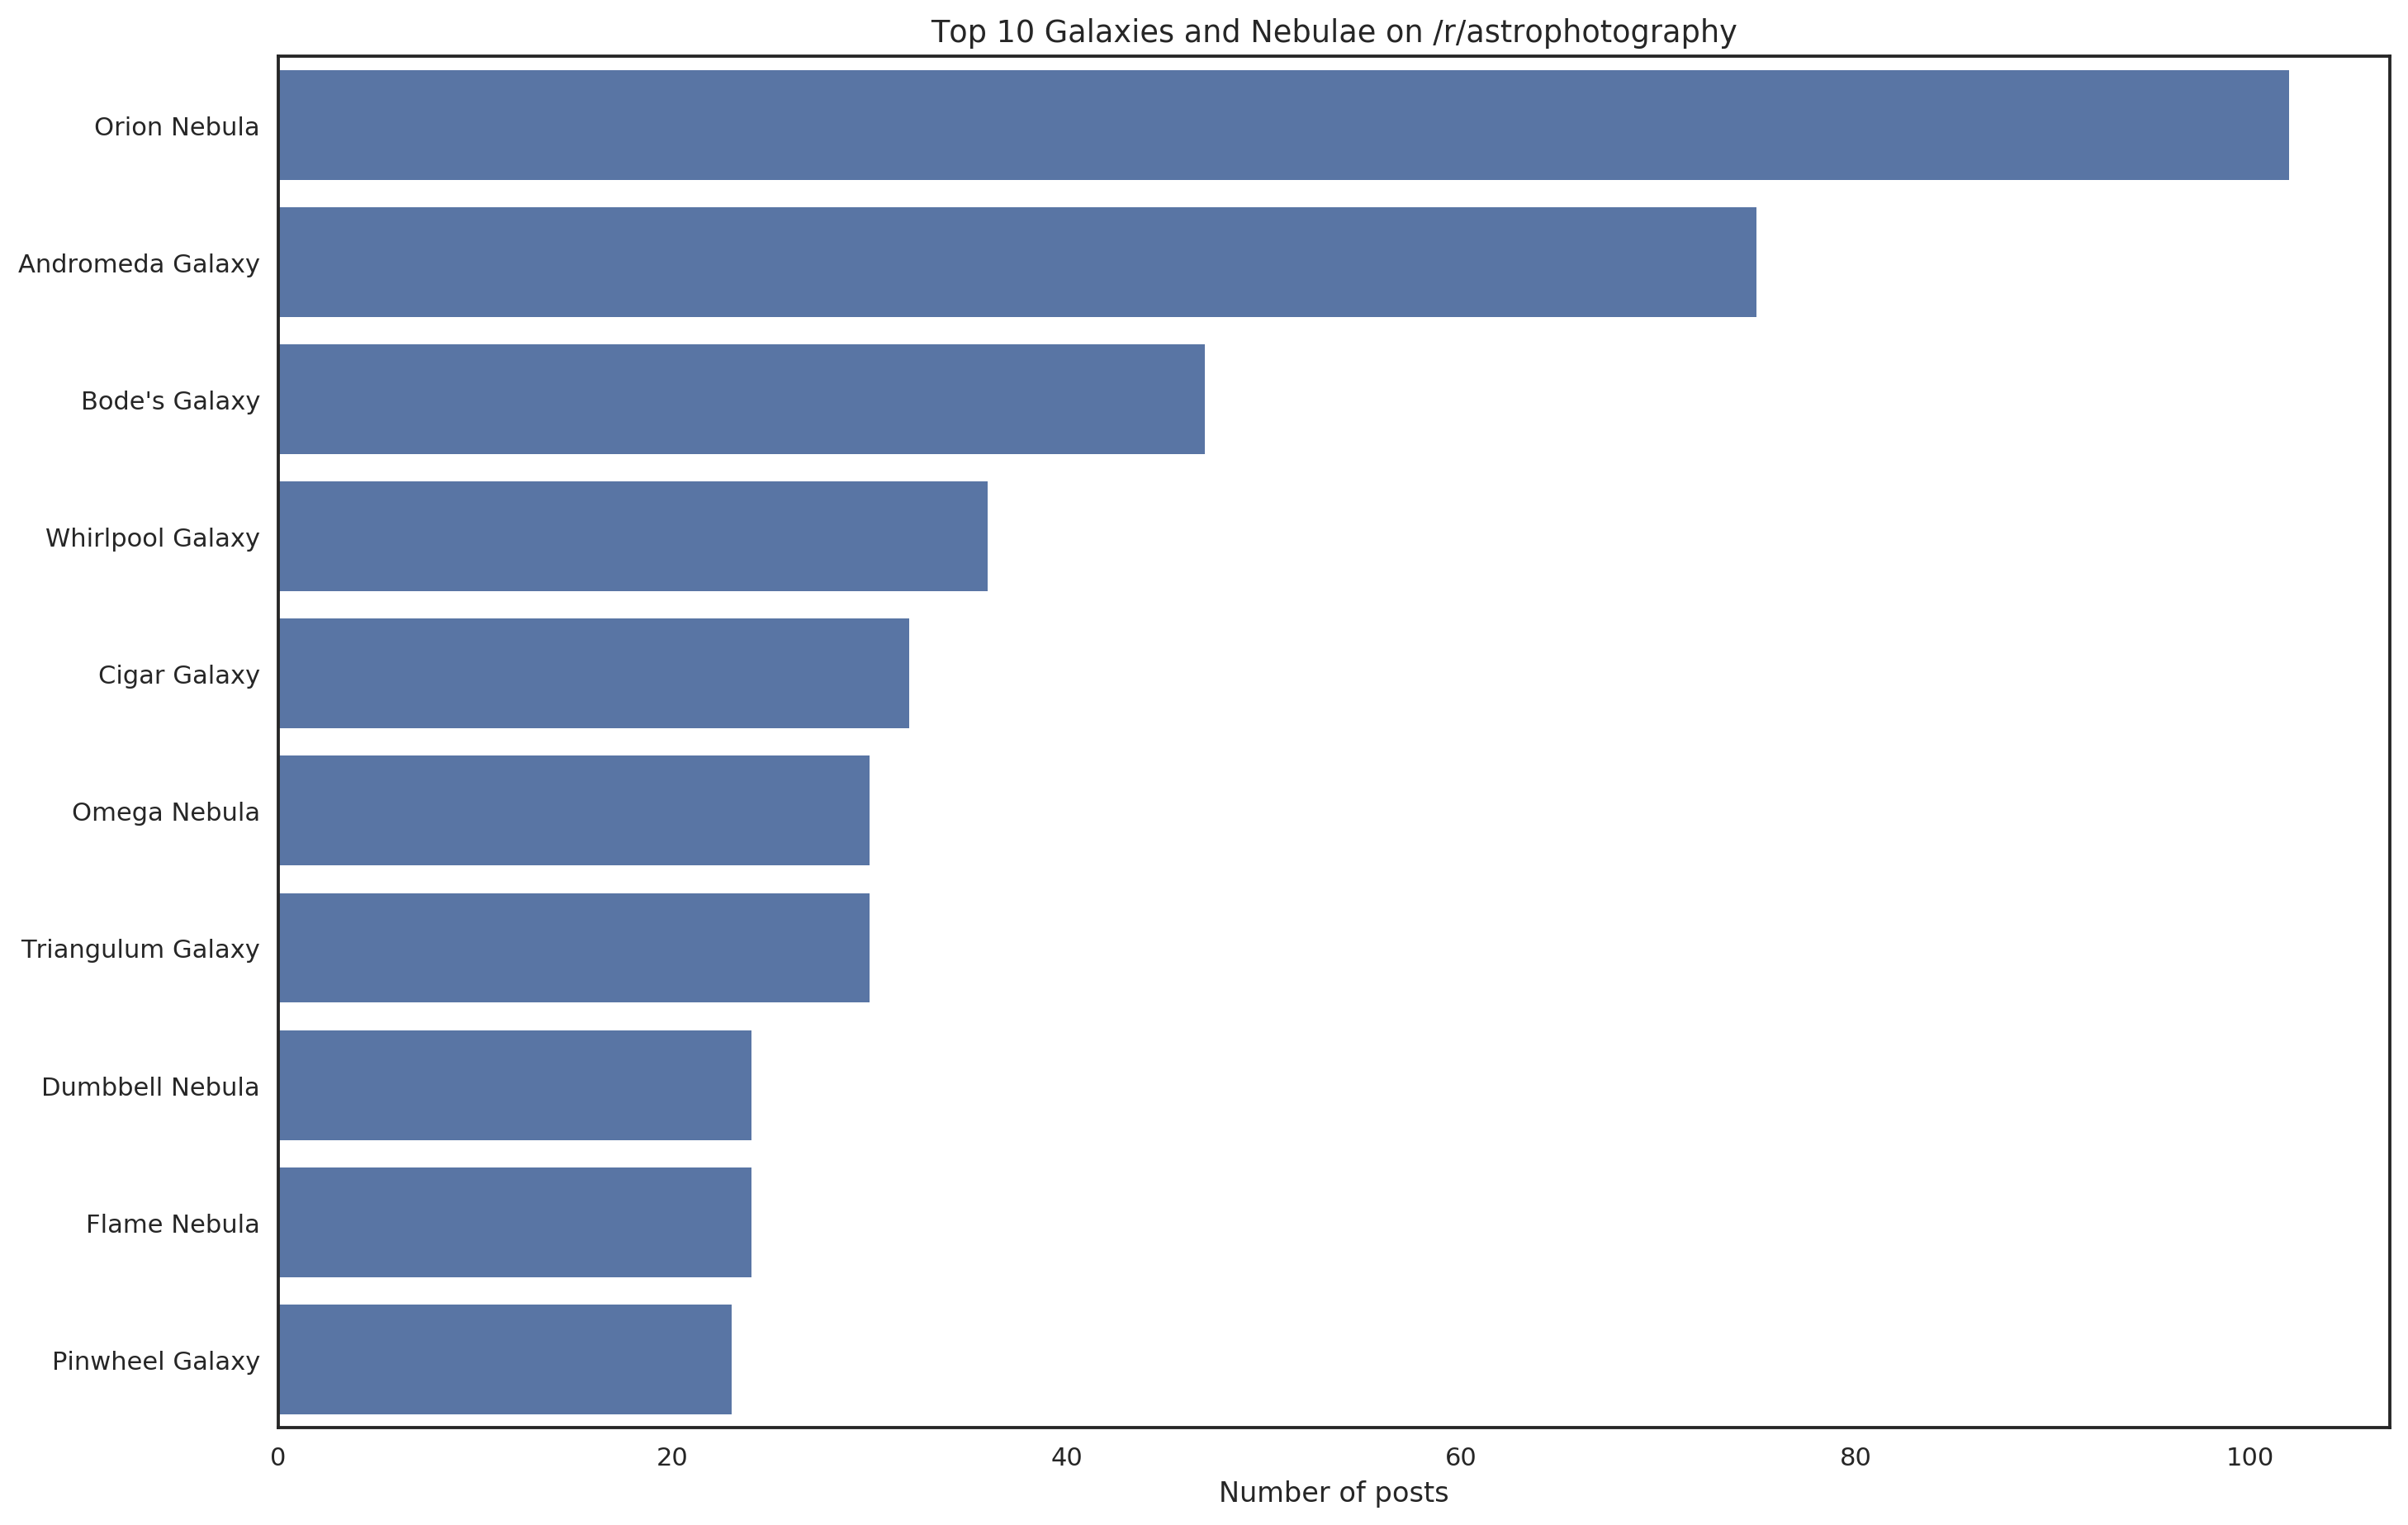

In [159]:
length = len(objectNames)
plt.figure(figsize=(15,10))
g=sns.barplot(y=objectNames,x=count[:length],orient='h',hue=np.ones(length))
plt.xlabel('Number of posts')
plt.ylabel('')
plt.title('Top 10 Galaxies and Nebulae on /r/astrophotography')
g.legend_.remove()